In [1]:
import torch
from torch import nn
import torch.distributions as d
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import random
from torch.autograd import Function
import os
import sys

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Generate Lotka-Volterra data

THETA = [.5, .0025, .3]

# define drift and diffusion matrix
def alpha(x, theta):
    return np.array([theta[0] * x[0] - theta[1] * x[0] * x[1], theta[1] * x[0] * x[1] - theta[2] * x[1]])

def beta(x, theta):
    M = np.array([[theta[0] * x[0] + theta[1] * x[0] * x[1], -theta[1] * x[0] * x[1]],
                    [-theta[1] * x[0] * x[1], theta[1] * x[0] * x[1] + theta[2] * x[1]]])
    return M

def sde_int(alpha, beta, T=50, dt=0.01, x0=[100., 100.], theta=THETA, observe_every=5., obs_std=1.):
    n = int(T/dt)+1
    m = int(T/observe_every)+1
    x = np.zeros([2, n])
    x[:, 0] = x0
    for i in range(1, n):
        x[:, i] = np.random.multivariate_normal(mean=x[:, i - 1] + alpha(x[:, i - 1], theta) * dt, cov=beta(x[:, i - 1], theta) * dt)
        x[:, i][x[:, i] < 1e-3] = 1e-3
    x_for_y = x[:, 0::int(observe_every/dt)]
    y = x_for_y + np.random.normal(0, obs_std, x_for_y.shape)
    return {'y': y, 't': np.arange(0, T+dt, observe_every), 'x': x, 'y_std': obs_std, 'x': x, 't_x': np.arange(0, T+dt, dt)}

obs= sde_int(alpha, beta)

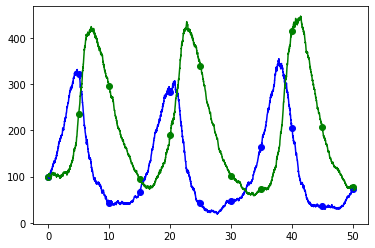

In [3]:
# Plot data: y dots are observations of latent x (line)

fig, axs = plt.subplots(1, 1)
axs.plot(obs['t_x'], obs['x'][0, :], color = "blue")
axs.plot(obs['t_x'], obs['x'][1, :], color = "green")
axs.scatter(obs['t'], obs['y'][0, :], color = "blue")
axs.scatter(obs['t'], obs['y'][1, :], color = "green")

In [4]:
# Code from flow_demo.py

class LowerBound(Function):
    @staticmethod
    def forward(ctx, inputs, bound):
        b = torch.ones(inputs.size()) * bound
        b = b.to(inputs.device)
        b = b.type(inputs.dtype)
        ctx.save_for_backward(inputs, b)
        return torch.max(inputs, b)
    @staticmethod
    def backward(ctx, grad_output):
        inputs, b = ctx.saved_tensors

        pass_through_1 = inputs >= b
        pass_through_2 = grad_output < 0

        pass_through = pass_through_1 | pass_through_2
        return pass_through.type(grad_output.dtype) * grad_output, None

class MaskedConv1d(nn.Conv1d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv1d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kW // 2 + 1*(mask_type == 'B'):] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv1d, self).forward(x)

class ResNetBlock(nn.Module):

    def __init__(self, inp_cha, out_cha, stride = 1, first=True, batch_norm=True):
        super().__init__()
        self.conv1 = MaskedConv1d('A' if first else 'B', inp_cha,  out_cha, 15, stride, 7, bias=False)
        self.conv2 = MaskedConv1d('B', out_cha,  out_cha, 15, 1, 7, bias=False)

        self.act1 = nn.PReLU(out_cha, init = 0.2)
        self.act2 = nn.PReLU(out_cha, init = 0.2)

        if batch_norm:
            self.bn1 = nn.BatchNorm1d(out_cha)
            self.bn2 = nn.BatchNorm1d(out_cha)
        else:
            self.bn1 = nn.Identity()
            self.bn2 = nn.Identity()

        # If dimensions change, transform shortcut with a conv layer
        if inp_cha != out_cha or stride > 1:
            self.conv_skip = MaskedConv1d('A' if first else 'B', inp_cha,  out_cha, 3, stride, 1, bias=False)
        else:
            self.conv_skip = nn.Identity()

    def forward(self, x):
        residual = x
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x) + self.conv_skip(residual)))
        return x

class ResNetBlockUnMasked(nn.Module):
    
    def __init__(self, inp_cha, out_cha, stride = 1, batch_norm=False):
        super().__init__()
        self.conv1 = nn.Conv1d(inp_cha,  out_cha, 15, stride, 7)
        self.conv2 = nn.Conv1d(out_cha,  out_cha, 15, 1, 7)

        self.act1 = nn.PReLU(out_cha, init = 0.2)
        self.act2 = nn.PReLU(out_cha, init = 0.2)

        if batch_norm:
            self.bn1 = nn.BatchNorm1d(out_cha)
            self.bn2 = nn.BatchNorm1d(out_cha)
        else:
            self.bn1 = nn.Identity()
            self.bn2 = nn.Identity()

        # If dimensions change, transform shortcut with a conv layer
        if inp_cha != out_cha or stride > 1:
            self.conv_skip = nn.Conv1d(inp_cha,  out_cha, 15, stride, 7, bias=False)
        else:
            self.conv_skip = nn.Identity()

    def forward(self, x):
        residual = x
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x) + self.conv_skip(residual)))
        return x

class CouplingLayer(nn.Module):

    def __init__(self, cond_inputs, stride):
        super().__init__()
        self.net = nn.Sequential(ResNetBlock(1+cond_inputs, 96, first=True),
                                 MaskedConv1d('B', 96,  2, 15, stride, 7, bias=False))

        self.feature_net = nn.Sequential(ResNetBlockUnMasked(cond_inputs, 96),
                                          ResNetBlockUnMasked(96, cond_inputs))
        
        self.unpack = True if cond_inputs > 1 else False

    def forward(self, x, cond_inputs):
        if self.unpack:
            cond_inputs = torch.cat([*cond_inputs], 1)
        cond_inputs = self.feature_net(cond_inputs)
        feature_vec = torch.cat([x, cond_inputs], 1)
        output = self.net(feature_vec)
        mu, sigma = torch.chunk(output, 2, 1)
        mu = self._pass_through_units(mu, mu=True)
        sigma = self._pass_through_units(sigma, mu=False)
        x = mu + sigma*x
        return x, sigma

    def _pass_through_units(self, params, mu=True):
        B, _, L = params.shape
        padding = 2 if STATE_DIM % 2==1 else 1
        if mu:
            pad = torch.zeros([B, padding, L], device=params.device)
        else:
            params = LowerBound.apply(params, 1e-2)
            pad = torch.ones([B, padding, L], device=params.device)
        return torch.cat([pad, params], 1).transpose(2, 1).reshape(B, 1, -1)

class PermutationLayer(nn.Module):

    def __init__(self):
        super().__init__()
        self.index = torch.randperm(STATE_DIM)

    def forward(self, x):
        B, S, L = x.shape
        x_reshape = x.reshape(B, S, -1, STATE_DIM)
        x_perm = x_reshape[:, :, :, self.index]
        x = x_perm.reshape(B, S, L)
        return x

class SDEFlow(nn.Module):

    def __init__(self, cond_inputs=1):
        super().__init__()

        stride = 3 if STATE_DIM % 2==1 else 2

        self.CL_1 = CouplingLayer(cond_inputs, stride)
        self.CL_2 = CouplingLayer(cond_inputs, stride)
        self.CL_3 = CouplingLayer(cond_inputs, stride)
        self.CL_4 = CouplingLayer(cond_inputs, stride)
        
        self.P_1 = PermutationLayer()
        self.P_2 = PermutationLayer()
        self.P_3 = PermutationLayer()

        self.base_dist = d.normal.Normal(loc=0., scale = 1.)

    def forward(self, batch_size, *args, **kwargs):

        eps = self.base_dist.sample([batch_size, 1, STATE_DIM*N]).to(device)
        log_prob = self.base_dist.log_prob(eps).sum(-1)

        times = torch.arange(0, T+dt, dt, device=eps.device)[(None,)*2].repeat(batch_size, STATE_DIM, 1).transpose(-2, -1).reshape(batch_size, 1, -1)

        CL_1, CL_1_sigma = self.CL_1(eps, times)
        P_1 = self.P_1(CL_1)

        CL_2, CL_2_sigma = self.CL_2(P_1, times)
        P_2 = self.P_2(CL_2)
        
        CL_3, CL_3_sigma = self.CL_3(P_2, times)
        P_3 = self.P_3(CL_3)

        y, CL_4_sigma = self.CL_4(P_3, times)

        for sigma in [CL_1_sigma, CL_2_sigma, CL_3_sigma]:
            log_prob -= torch.log(sigma).sum(-1)
        
        return LowerBound.apply(y.reshape(batch_size, STATE_DIM, -1).permute(0, 2, 1), 1e-3), log_prob


In [5]:
# define drift and diffusion for pytorch

def alpha(x, theta):
    alpha_vec = torch.cat([theta[0] * x[:, :, 0:1] - theta[1] * x[:, :, 0:1] * x[:, :, 1:2], theta[1] * x[:, :, 0:1] * x[:, :, 1:2] - theta[2] * x[:, :, 1:2]], -1)
    return alpha_vec

def beta_tril(x, theta):
    M = torch.empty([x.size(0), x.size(1), 2, 2], device = x.device)
    M[:, :, 0:1, 0] = theta[0] * x[:, :, 0:1] + theta[1] * x[:, :, 0:1] * x[:, :, 1:2]
    M[:, :, 0:1, 1] = -theta[1] * x[:, :, 0:1] * x[:, :, 1:2]
    M[:, :, 1:2, 0] = -theta[1] * x[:, :, 0:1] * x[:, :, 1:2]
    M[:, :, 1:2, 1] = theta[1] * x[:, :, 0:1] * x[:, :, 1:2] + theta[2] * x[:, :, 1:2]
    return torch.cholesky(M)

# Observation model

class ObsModel(nn.Module):

    def __init__(self, times, mu, scale):
        super().__init__()

        self.idx = self._get_idx(times)
        self.times = times
        self.mu = torch.Tensor(mu).to(device)
        self.scale = scale
        
    def forward(self, x):
            obs_ll = d.normal.Normal(self.mu.permute(1, 0), self.scale).log_prob(x[:, self.idx, :])
            return torch.sum(obs_ll, [-1, -2]).mean()

    def _get_idx(self, times):
        return list((times/dt).astype(int))    

# function to calculate negative log_lik

def neg_log_lik(x, alpha, beta_sqrt):
    euler_maruyama = d.multivariate_normal.MultivariateNormal(loc=x[:, :-1, :] + alpha(x[:, :-1, :], THETA)*dt, scale_tril = beta_tril(x[:, :-1, :], THETA)*math.sqrt(dt))
    return -euler_maruyama.log_prob(x[:, 1:, :]).sum(-1)

In [8]:
STATE_DIM = 2
dt = .2
T = obs['t'][-1]
N = int(T/dt)+1
BATCH_SIZE = 30
CUDA_ID = 1

device = torch.device("".join(["cuda:",f'{CUDA_ID}']) if torch.cuda.is_available() else "cpu")
LR = 1e-3

net = SDEFlow().to(device)
obs_model = ObsModel(obs['t'], obs['y'], obs['y_std'])
optimizer = optim.Adam(net.parameters(), lr=LR)

In [9]:
print("\n obs['t']", obs['t'])
print("\n obs['y']", obs['y'])
print("\n obs['y_std']", obs['y_std'])


 obs['t'] [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]

 obs['y'] [[ 99.79788297 321.54184173  43.62367853  67.57601781 282.37811044
   43.27985264  47.18691055 164.40397254 204.12576022  35.89615976
   74.0214217 ]
 [ 98.6414776  236.11017967 296.24083652  94.21270234 190.76642922
  339.76747581 101.86551165  72.2312199  413.43828371 207.14039777
   77.13594167]]

 obs['y_std'] 1.0


In [12]:
# plot approx solution
def plot():
    net.eval()
    with torch.no_grad():
        x, _ = net(100)
    x_np = x.detach().cpu().numpy()
    for i in range(x_np.shape[0]):
        plt.plot(np.arange(0, T+dt, dt), x_np[i, :, 0], color="blue")
        plt.plot(np.arange(0, T+dt, dt), x_np[i, :, 1], color="green")
    plt.scatter(obs['t'], obs['y'][0, :], color = "blue", zorder=1)
    plt.scatter(obs['t'], obs['y'][1, :], color = "green", zorder=1)
    plt.show()
    plt.close()

# train
def train(niter):
    for iter in range(niter):
        net.train()
        optimizer.zero_grad()
        x, log_prob = net(BATCH_SIZE)
        print('x size', x.size())
        log_lik = neg_log_lik(x, alpha, beta_tril) 
        ELBO = log_prob.mean() + log_lik.mean() - obs_model(x)
        ELBO.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 2.50)
        optimizer.step()
        if iter % 1000 == 0:
            print(f"Loss at iteration {iter} is: {ELBO}")
        if iter % 5000 == 0 and iter > 0:
            optimizer.param_groups[0]['lr'] *= 0.1

In [13]:
train(1)

x size torch.Size([30, 251, 2])
Loss at iteration 0 is: 636431.4375


In [ ]:
# plot approx solution after training
plot()